In [37]:
#Import libraries
import os
import string
import math
import numpy as np
from numpy import *
import scipy.constants
from decimal import Decimal

In [38]:
#Setup matplotlib defaults
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Adjust the plot line thickness, tick mark thickness, etc.
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['xtick.minor.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.width'] = 2

#Set blue colour map
norm = matplotlib.colors.Normalize(1,20)
cmap = cm.ScalarMappable(norm=norm, cmap=cm.PuBu)
cmap.set_array([])

# Fast Cooling Shock Bubble
- (t=10^2,10^3,10^4,10^5,10^6)
- Gas velocity equations from Weaver1977
- Initial parameters and shock feature equations from FG2012


## *To edit this code:
- TO CHANGE INITIAL WIND VELCOITY, USE EDIT: FIND AND REPLACE
    - VALUES: 10k, 20k, 30k, 40k, 50k
    - Don't include decimals when using find and replace because value in plot titles as well

## Set Initial Param

In [39]:
#Initial parameters
#alpha= 1.0 #0 < alpha < 2
alpha_FG= 0.921 #dimensionless constant
L_AGN = 10.0**46.0 #erg/s = (g*cm^2/s^2)/s
nH_0= 100.0 # particles/cm^3
rho_0 = nH_0*(scipy.constants.m_p*1000.0) #g/cm^3
rho_ISM=rho_0
vin= 10000.0*(10.0**5.0) #cm/s, was 10000.0 km/s
R0= 100.0*(3.086*(10.0**18)) #cm, was pc for all numerical sim
Tin = 1.0 #dimensionless
c= scipy.constants.c*(100.0) #cm/s, was m/s

L_in=(0.5)*L_AGN*Tin*(vin/c)
M_out = (2.0*L_in)/(vin**2.0) #g/s, ~2 solar masses/year (not 1)
mu=14.0/23.0 #from other paper, mean mass per particle
k = scipy.constants.k*(10.0**7.0)

        
#Constants for calculating R values for energy conserving shock in FG2012 AppendixA
def A_E(alpha):
    A_E = ((((5.0-alpha)**2.0)*(3.0-alpha)*L_in)/(36.0*np.pi*rho_0*(R0**alpha)))**(1.0/(5.0-alpha))
    return A_E
def Beta_E(alpha):
    Beta_E = 3.0/(5.0-alpha)
    return Beta_E

## CALCULATE 1st TIMESTEP (t)

In [40]:
t1=[]
R2_t1=[];vsh_t1=[];R1_t1=[];Rc_t1=[]
dR2_dt1=[]
vg_t1 = {}; r_t1 = {}; p_t1 = {}
N_t=[]

Rf_t1=[]
Rc_ind1_t=[]

vg1_R1=[None]*5;vg1_Rc=[None]*5;vg1_R2=[None]*5
p1_R1=[None]*5;p1_Rc=[None]*5;p1_R2=[None]*5

#density distribution parameter
alpha= 0.0

#Loop through each of the 5 time epochs
for i in range(5):
    
    #Determine timesteps using range 10^2 yr < t < 10^6 yrS
    t1.append(((10.0**(3.0+i))*(3.154*(10.0**7.0)))) #s, was 10^2 yr < t < 10^9 yr    
    #ADDED t=10^3.5 yrs epoch
    if i == 4:
        t1[i] = (10.0**(3.5))*(3.154*(10.0**7.0))
        
    #Calculate radius of outer shock feature (R2) based on t (FG2012)
    R2_t1.append(A_E(alpha)*(t1[i]**Beta_E(alpha)))
    vsh_t1.append((Beta_E(alpha)*R2_t1[i])/(t1[i])) #Time derivative of R2
    
    #Solve cubic equation for R1 (FG2012)
    coeff = [1.0, 0.5*vin*t1[i], 0, -((R2_t1[i])**3.0)]
    roots=np.roots(coeff)
    real_root = roots[np.isreal(roots)].real
    for j in range(np.size(real_root)):
        if real_root[j] > 0:
            R1_t1.append(float(real_root[j]))
    
    Rc_t1.append(0.86*R2_t1[i])
    
    Rf_t1.append((L_in/(2.0*np.pi*rho_0*(vin**3.0)))**0.5)

    #Define equal width radius bins    
    num= 10001
    radius1 = np.linspace(10.0**(17.0),(R2_t1[i]*1.2),num) #cm, was 10^-1 pc < R < 10^4 pc
    
    vg1_r=[]; p1_r=[]
    N1=[]; N1.append(0)
    
    cnt1=0

    #Calculate vgas and density in different regions of shock bubble
    #---Values at boundary calculated in last bin before moving to next region
    for r in radius1:
        if r<R1_t1[i]:
            vg= vin
            p= M_out/(4.0*np.pi*(r**2.0)*vg)
            vg1_r.append(vg)
            p1_r.append(p)
            
            vg1_R1[i] = (vin/4.0)/(10.0**5.0)
            p1_R1[i] = (M_out/(np.pi*(r**2.0)*vin))/(scipy.constants.m_p*1000.0)
            
        elif R1_t1[i]<r<Rc_t1[i]:
            vg= (11.0/25.0)*((Rc_t1[i]**3.0)/((r**2.0)*t1[i]))+(4.0/25.0)*(r/t1[i])
            p= 0.628*(((M_out**2.0)*(rho_0**3.0)*(vin**-6.0))**0.2)*(t1[i]**-0.8)*((1-((r**3.0)/(Rc_t1[i]**3.0)))**(-8.0/33.0))
            vg1_r.append(vg)
            p1_r.append(p)
            
            vg1_Rc[i] = (0.86*vsh_t1[i])/(10.0**5.0)
            p1_Rc[i] = (0.4*4.0*rho_ISM)/(scipy.constants.m_p*1000.0)
            Rc_ind1=cnt1
        elif Rc_t1[i]<r<R2_t1[i]:
            #Assuming linear
            vg= (vsh_t1[i]/(Rc_t1[i]-R2_t1[i]))*((0.11*r)+(0.75*Rc_t1[i])-(0.86*R2_t1[i]))
            p= (rho_ISM/(Rc_t1[i]-R2_t1[i]))*((-2.4*r)+(4.0*Rc_t1[i])-(1.6*R2_t1[i]))
            vg1_r.append(vg)
            p1_r.append(p)
                        
            vg1_R2[i] = (0.75*vsh_t1[i])/(10.0**5.0)
            p1_R2[i] = (4.0*rho_ISM)/(scipy.constants.m_p*1000.0)

        elif r>R2_t1[i]:
            vg= 0.0
            p= rho_ISM
            vg1_r.append(vg)
            p1_r.append(p)
            
        else:
            print('missed')
            
        cnt1+=1
    
    Rc_ind1_t.append(Rc_ind1)
    
    #Convert units
    t1[i]=t1[i]/(3.154*(10.0**7.0)) #convert from s to yrs
    R1_t1[i]= R1_t1[i]/(3.086*(10.0**18)); Rc_t1[i]= Rc_t1[i]/(3.086*(10.0**18)); R2_t1[i]= R2_t1[i]/(3.086*(10.0**18)) #convert from cm to pc
    Rf_t1[i]= Rf_t1[i]/(3.086*(10.0**18))
    
    for j in range(0,len(radius1)):
        radius1[j]= radius1[j]/(3.086*(10.0**18)) #convert from cm to pc
        vg1_r[j]=vg1_r[j]/(10.0**5.0) #convert from cm/s to km/s
        p1_r[j]=p1_r[j]/(scipy.constants.m_p*1000.0)  #!!!CONVERT FROM G/CM^3 BACK TO CM^-3??? --> yes
    
    #Add list for time epoch to dictionary where key is i+1 
    #--- t=10^2yrs --> 1, ..., t=10^6yrs --> 4
    r_t1[i+1] = radius1
    vg_t1[i+1] = vg1_r
    p_t1[i+1] = p1_r
    
print(Rf_t1)

[4.082158898382663, 4.082158898382663, 4.082158898382663, 4.082158898382663, 4.082158898382663]


## CALCULATE 2nd TIMESTEP (t+10yrs)

In [41]:
t2=[]
R2_t2=[];vsh_t2=[];R1_t2=[];Rc_t2=[]
dR2_dt2=[]
vg_t2={};r_t2={};p_t2={}
N_t2={}

Rc_ind2_t=[]

vg2_R1=[None]*5;vg2_Rc=[None]*5;vg2_R2=[None]*5
p2_R1=[None]*5;p2_Rc=[None]*5;p2_R2=[None]*5

#Loop through each of the 5 time epochs
for i in range(5):
    
    #Determine timesteps using range 10^2 yr < t < 10^6 yr and t+10yrs
    t2.append((((10.0**(3.0+i))+10.0)*(3.154*(10.0**7.0)))) #s, was 10^2 yr < t < 10^9 yr
    #ADDED t=10^3.5 yrs epoch
    if i == 4:
        t2[i] = ((10.0**(3.5))+10.0)*(3.154*(10.0**7.0)) 
    
    #Calculate radius of outer shock feature (R2) based on t (FG2012)
    R2_t2.append(A_E(alpha)*(t2[i]**Beta_E(alpha)))
    vsh_t2.append((Beta_E(alpha)*R2_t2[i])/(t2[i])) #Time derivative of R2
    
    #Solve cubic equation for R1 (FG2012)
    coeff = [1.0, 0.5*vin*t2[i], 0, -((R2_t2[i])**3.0)]
    roots=np.roots(coeff)
    real_root = roots[np.isreal(roots)].real
    for j in range(np.size(real_root)):
        if real_root[j] > 0:
            R1_t2.append(float(real_root[j]))
    
    Rc_t2.append(0.86*R2_t2[i])
    
    #Define equal width radius bins     
    num= 10001
    radius2 = np.linspace(10.0**(17.0),(R2_t2[i]*1.2),num) #cm, was 10^-1 pc < R < 10^4 pc
    
    vg2_r=[]; p2_r=[]
    N2=[]; N2.append(0)
    
    cnt2=0
    
    #Calculate vgas and density in different regions of shock bubble
    #---Values at boundary calculated in last bin before moving to next region
    for r in radius2:
        if r<R1_t2[i]:
            vg= vin
            p= M_out/(4.0*np.pi*(r**2.0)*vg)
            vg2_r.append(vg)
            p2_r.append(p)
            
            vg1_R2[i] = (vin/4.0)/(10.0**5.0)
            p1_R2[i] = (M_out/(np.pi*(r**2.0)*vin))/(scipy.constants.m_p*1000.0)
            
        elif R1_t2[i]<r<Rc_t2[i]:
            vg= (11.0/25.0)*((Rc_t2[i]**3.0)/((r**2.0)*t2[i]))+(4.0/25.0)*(r/t2[i])
            p= 0.628*(((M_out**2.0)*(rho_0**3.0)*(vin**-6.0))**0.2)*(t2[i]**-0.8)*((1-((r**3.0)/(Rc_t2[i]**3.0)))**(-8.0/33.0))
            vg2_r.append(vg)
            p2_r.append(p)
                        
            vg2_Rc[i] = (0.86*vsh_t2[i])/(10.0**5.0)
            p2_Rc[i] = (0.4*4.0*rho_ISM)/(scipy.constants.m_p*1000.0)
            Rc_ind2=cnt2
        elif Rc_t2[i]<r<R2_t2[i]:
            #Assuming linear
            vg= (vsh_t2[i]/(Rc_t2[i]-R2_t2[i]))*((0.11*r)+(0.75*Rc_t2[i])-(0.86*R2_t2[i]))
            p= (rho_ISM/(Rc_t2[i]-R2_t2[i]))*((-2.4*r)+(4.0*Rc_t2[i])-(1.6*R2_t2[i]))
            vg2_r.append(vg)
            p2_r.append(p)
                        
            vg2_R2[i] = (0.75*vsh_t2[i])/(10.0**5.0)
            p2_R2[i] = (4.0*rho_ISM)/(scipy.constants.m_p*1000.0)

        elif r>R2_t2[i]:
            vg= 0.0
            p= rho_ISM
            vg2_r.append(vg)
            p2_r.append(p)
                        
        else:
            print('missed')
            
        cnt2+=1
        
    Rc_ind2_t.append(Rc_ind2)   
    
    #Convert units
    t2[i]=t2[i]/(3.154*(10.0**7.0)) #convert from s to yrs
    R1_t2[i]= R1_t2[i]/(3.086*(10.0**18)); Rc_t2[i]= Rc_t2[i]/(3.086*(10.0**18)); R2_t2[i]= R2_t2[i]/(3.086*(10.0**18)) #convert from cm to pc

    for j in range(0,len(radius2)):
        radius2[j]= radius2[j]/(3.086*(10.0**18)) #convert from cm to pc
        vg2_r[j]=vg2_r[j]/(10.0**5.0) #convert from cm/s to km/s
        p2_r[j]=p2_r[j]/(scipy.constants.m_p*1000.0)  #!!!CONVERT FROM G/CM^3 BACK TO CM^-3??? --> yes
        
    #Add list for time epoch to dictionary where key is i+1 
    #--- t=10^2yrs --> 1, ..., t=10^6yrs --> 4
    r_t2[i+1] = radius2
    vg_t2[i+1] = vg2_r
    p_t2[i+1] = p2_r

## CALCULATE dv/dt & N BETWEEN TIMESTEPS (t and t+10yrs)

In [42]:
dr1_dm={}; dr2_dm={}
r1_dm={}; r2_dm={}
v1_dm={}; v2_dm={}
p1_dm={}; p2_dm={}
N1_dm={}; N2_dm={}
dv_dt={}

r1_dm_cut={};r2_dm_cut={}
v1_dm_cut={};v2_dm_cut={}
dv_dt_cut={}

for i in range(5):
    #Calculate constant mass element dM using dRc=Rc(t2)-Rc(t1)
    #---Remember to convert R values from pc back to cm to get correct units
    dM=((((Rc_t1[i]+Rc_t1[i])*(3.086*(10.0**18)))/2.0)**2.0)*((p1_Rc[i]+p2_Rc[i])/2.0)*((Rc_t2[i]-Rc_t1[i])*(3.086*(10.0**18)))
    #print(dM)

    dr1=[]; dr1_sh=[]
    r1=[]; r1_sh=[]
    v1=[]; v1_sh=[]
    p1=[];p1_sh=[]
    N1=[];N1_sh=[]
    
    r1_cut=[];r1_sh_cut=[]
    v1_cut=[];v1_sh_cut=[]

    #Calculate first of all values at Rc then will work outwards in both directions
    dr1.append(Rc_t2[i]-Rc_t1[i]); dr1_sh.append(Rc_t2[i]-Rc_t1[i])
    r1.append(Rc_t1[i]); r1_sh.append(Rc_t1[i])
    v1.append(vg1_Rc[i]); v1_sh.append(vg1_Rc[i])
    p1.append(p1_Rc[i]); p1_sh.append(p1_Rc[i])    
    
    dr2=[];dr2_sh=[]
    r2=[]; r2_sh=[]
    v2=[]; v2_sh=[]
    p2=[]; p2_sh=[]
    N2=[]; N2_sh=[]
    
    r2_cut=[];r2_sh_cut=[]
    v2_cut=[]; v2_sh_cut=[]

    dr2.append(Rc_t2[i]-Rc_t1[i]); dr2_sh.append(Rc_t2[i]-Rc_t1[i])
    r2.append(Rc_t2[i]); r2_sh.append(Rc_t2[i])
    v2.append(vg2_Rc[i]); v2_sh.append(vg2_Rc[i])
    p2.append(p2_Rc[i]); p2_sh.append(p2_Rc[i])

    m=0;n=0
    #Using constant dm, define dr working outwards from Rc for FIRST TIMESTEP (t)
    #---Find velocities and densities that correspond to dr bins for t
    for j in range(0,len(r_t1[i+1])-1):
        #Working from Rc inwards to R1 (unshocked wind)
        if r_t1[i+1][len(r_t1[i+1])-j-1] <= r1[m] :
            dr1.append((dM/((((r_t1[i+1][len(r_t1[i+1])-j-1]*(3.086*(10.0**18)))**2.0)*(p_t1[i+1][len(r_t1[i+1])-j-1]))))/(3.086*(10.0**18)))
            r1.append(r_t1[i+1][len(r_t1[i+1])-j-1]-dr1[m+1])
            v1.append(vg_t1[i+1][len(r_t1[i+1])-j-1])
            p1.append(p_t1[i+1][len(r_t1[i+1])-j-1])
            
            #Define cut selection excluding region r<R1
            if r1[m]>R1_t1[i]:
                r1_cut.append(r1[m+1])
                v1_cut.append(v1[m+1])
                
                #Calculate N for defined dr bin (for timestep 1)
                #--- Units p: [cm^-3], v: [km/s], dr: [pc] --> [cm]
                N1.append((((p1[m]+p1[m+1])/2.0)/np.abs(v1[m]-v1[m+1]))*(dr1[m+1]*(3.086*(10.0**18))))
        
            m+=1
        
        #Working from Rc outwards to R2 (shocked wind)
        if r_t1[i+1][j] >= r1_sh[n]:
            dr1_sh.append((dM/((((r_t1[i+1][j]*(3.086*(10.0**18)))**2.0)*(p_t1[i+1][j]))))/(3.086*(10.0**18)))
            r1_sh.append(r_t1[i+1][j]+dr1_sh[n+1])
            v1_sh.append(vg_t1[i+1][j]) 
            p1_sh.append(p_t1[i+1][j])
            
            #Define cut selection excluding region r>R2
            if r1_sh[n+1]<R2_t1[i]:
                r1_sh_cut.append(r1_sh[n+1])
                v1_sh_cut.append(v1_sh[n+1])
                
                #Calculate N for defined dr bin (for timestep 1)
                N1_sh.append((((p1_sh[n]+p1_sh[n+1])/2.0)/np.abs(v1_sh[n]-v1_sh[n+1]))*(dr1_sh[n+1]*(3.086*(10.0**18))))
        
            n+=1

    m=0;n=0
    #Using constant dm, define dr working outwards from Rc for SECOND TIMESTEP (t+10yrs)
    #---Find velocities and densities that correspond to dr bins for t
    for j in range(0,len(r_t2[i+1])-1):
        #Working from Rc inwards to R1 (unshocked wind)
        if r_t2[i+1][len(r_t2[i+1])-j-1] <= r2[m] :
            dr2.append((dM/((((r_t2[i+1][len(r_t2[i+1])-j-1]*(3.086*(10.0**18)))**2.0)*(p_t2[i+1][len(r_t2[i+1])-j-1]))))/(3.086*(10.0**18)))
            r2.append(r_t2[i+1][len(r_t2[i+1])-j-1]-dr2[m+1])
            v2.append(vg_t2[i+1][len(r_t2[i+1])-j-1])
            p2.append(p_t2[i+1][len(r_t2[i+1])-j-1])
            
            #Define cut selection excluding region r<R1
            if r2[m]>R1_t2[i]:
                r2_cut.append(r2[m+1])
                v2_cut.append(v2[m+1])
                
                #Calculate N for defined dr bin (for timestep 2)
                N2.append((((p2[m]+p2[m+1])/2.0)/np.abs(v2[m]-v2[m+1]))*(dr2[m+1]*(3.086*(10.0**18))))
        
            m+=1
        
        #Working from Rc outwards to R2 (shocked wind)
        if r_t2[i+1][j] >= r2_sh[n]:
            dr2_sh.append((dM/((((r_t2[i+1][j]*(3.086*(10.0**18)))**2.0)*(p_t2[i+1][j]))))/(3.086*(10.0**18)))
            r2_sh.append(r_t2[i+1][j]+dr2_sh[n+1])
            v2_sh.append(vg_t2[i+1][j]) 
            p2_sh.append(p_t2[i+1][j])
            
            #Define cut selection excluding region r>R2
            if r2_sh[n+1]<R2_t2[i]:
                r2_sh_cut.append(r2_sh[n+1])
                v2_sh_cut.append(v2_sh[n+1])
                
                #Calculate N for defined dr bin (for timestep 2)
                N2_sh.append((((p2_sh[n]+p2_sh[n+1])/2.0)/np.abs(v2_sh[n]-v2_sh[n+1]))*(dr2_sh[n+1]*(3.086*(10.0**18))))
        
            n+=1
        
    #SECOND TIMESTEP (t+10yrs) has one more bin at end than FIRST TIMESTEP (t) (for the cut values)...just remove last one
    r2_sh_cut.pop(); v2_sh_cut.pop(); N2_sh.pop()
    
    #Calculate dv/dt between FIRST AND SECOND TIMESTEP (t and t+10) before and after shock (boundary Rc)
    dvdt=[];dvdt_sh=[]
    dvdt_cut=[];dvdt_sh_cut=[]
    for j in range(0,len(v1)):
        #Check bin doesn't span over R1 boundary making v_gas jump
        if v1[j] !=10000 and v2[j] ==10000:
            dvdt_sh.append(0.0)
        else:
            dv= np.abs(v2[j]-v1[j])
            dvdt.append(dv/10.0)
            
            #Define cut selection excluding region r<R1
            if r1[j]>R1_t1[i]:
                dvdt_cut.append(dv/10.0)

    
    for j in range(0,len(v1_sh)):
        #Check bin doesn't span over R2 boundary making v_gas jump
        if v1_sh[j] ==0 and v2_sh[j] !=0:
            dvdt_sh.append(0.0)
        else:
            dv_sh = np.abs(v2_sh[j]-v1_sh[j])
            dvdt_sh.append(dv_sh/10.0)
            
            #Define cut selection excluding region r>R2
            if r1_sh[j]<R2_t1[i]:
                dvdt_sh_cut.append(dv_sh/10.0)
                
    dvdt_sh_cut.pop()
        
    #Add lists to dictionary for corresponding time
    #---Reverse unshocked wind lists because worked inwards from Rc
    dr1.reverse(); dr1.extend(dr1_sh); dr1_dm[i+1]=dr1
    r1.reverse(); r1.extend(r1_sh); r1_dm[i+1]=r1
    v1.reverse(); v1.extend(v1_sh); v1_dm[i+1]=v1
    p1.reverse(); p1.extend(p1_sh); p1_dm[i+1]=p1
    N1.reverse(); N1.extend(N1_sh); N1_dm[i+1]=N1
    
    r1_cut.reverse(); r1_cut.extend(r1_sh_cut); r1_dm_cut[i+1]=r1_cut
    v1_cut.reverse(); v1_cut.extend(v1_sh_cut); v1_dm_cut[i+1]=v1_cut
    
    dr2.reverse(); dr2.extend(dr2_sh); dr2_dm[i+1]=dr2
    r2.reverse(); r2.extend(r2_sh); r2_dm[i+1]=r2
    v2.reverse(); v2.extend(v2_sh); v2_dm[i+1]=v2
    p2.reverse(); p2.extend(p2_sh); p2_dm[i+1]=p2
    N2.reverse(); N2.extend(N2_sh); N2_dm[i+1]=N2
    
    r2_cut.reverse(); r2_cut.extend(r2_sh_cut); r2_dm_cut[i+1]=r2_cut
    v2_cut.reverse(); v2_cut.extend(v2_sh_cut); v2_dm_cut[i+1]=v2_cut
    
    dvdt.reverse(); dvdt.extend(dvdt_sh); dv_dt[i+1]=dvdt
    dvdt_cut.reverse(); dvdt_cut.extend(dvdt_sh_cut); dv_dt_cut[i+1]=dvdt_cut

#Print sizes to double check
"""
print(np.size(N1_dm[1])); print(np.size(r1_dm_cut[1])); print(np.size(v1_dm_cut[1]))
print(np.size(dv_dt_cut[1]))
print(np.size(N2_dm[1])); print(np.size(r2_dm_cut[1])); print(np.size(v2_dm_cut[1]))

print(r1_dm[1][1])
print(dr1_dm[1][1])
print(p1_dm[1][1])
print(v1_dm[1][2]-v1_dm[1][1])
print(N1_dm[1][1])
"""

'\nprint(np.size(N1_dm[1])); print(np.size(r1_dm_cut[1])); print(np.size(v1_dm_cut[1]))\nprint(np.size(dv_dt_cut[1]))\nprint(np.size(N2_dm[1])); print(np.size(r2_dm_cut[1])); print(np.size(v2_dm_cut[1]))\n\nprint(r1_dm[1][1])\nprint(dr1_dm[1][1])\nprint(p1_dm[1][1])\nprint(v1_dm[1][2]-v1_dm[1][1])\nprint(N1_dm[1][1])\n'

# Original Var Plots (v_gas, p)

## Plot R1, R2, and Rc vs time 

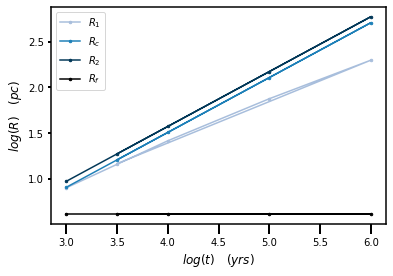

In [43]:
#---Plot R1, R2, snd Rc vs time 
plt.plot(np.log10(t1),np.log10(R1_t1),c=cmap.to_rgba(8),linestyle="-",marker='.',markersize=5,label=r'$R_1$')
plt.plot(np.log10(t1),np.log10(Rc_t1),c=cmap.to_rgba(14),linestyle="-",marker='.',markersize=5,label=r'$R_c$')
plt.plot(np.log10(t1),np.log10(R2_t1),c=cmap.to_rgba(20),linestyle="-",marker='.',markersize=5,label=r'$R_2$')
plt.plot(np.log10(t1),np.log10(Rf_t1),c='black',linestyle="-",marker='.',markersize=5,label=r'$R_f$')

plt.legend(loc='upper left')
plt.ylabel(r'$log(R) \quad (pc)$', fontsize=12)
plt.xlabel(r'$log(t) \quad (yrs)$', fontsize=12)
#plt.savefig('vw10000/ShockBubble_logrVSlogt_vw10000.png',bbox_inches='tight')
plt.show()

## MAIN vgas PLOT

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5

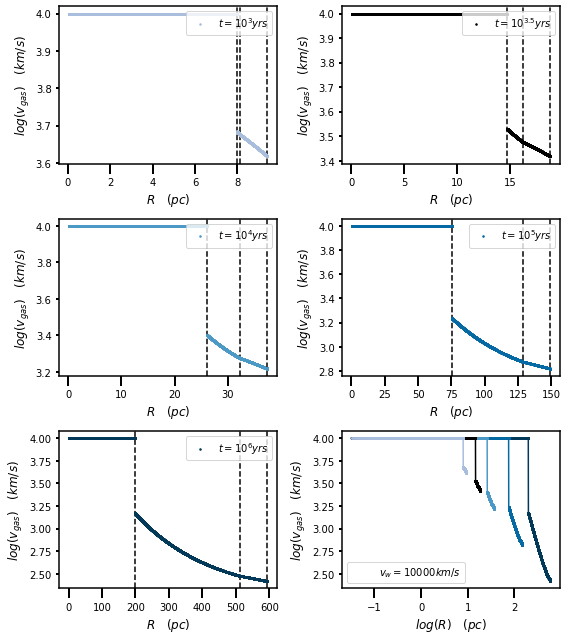

In [44]:
#---Plot log(vgas) vs R for different timesteps

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 9))
#---t=10^3yr
axes[0,0].axvline(x=R1_t1[0],color='black',linestyle="--")
axes[0,0].axvline(x=Rc_t1[0],color='black',linestyle="--")
axes[0,0].axvline(x=R2_t1[0],color='black',linestyle="--")
axes[0,0].plot((r_t1[1]),np.log10(vg_t1[1]),c=cmap.to_rgba(8),linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
#axes[0,0].set_ylim(2.4,4.4)
#axes[0,0].set_xlim(0,15)
axes[0,0].set_ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
axes[0,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,0].legend(loc='upper right')
#---t=10^3.5yr
axes[0,1].axvline(x=R1_t1[4],color='black',linestyle="--")
axes[0,1].axvline(x=Rc_t1[4],color='black',linestyle="--")
axes[0,1].axvline(x=R2_t1[4],color='black',linestyle="--")
axes[0,1].plot((r_t1[5]),np.log10(vg_t1[5]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{3.5} yrs$')
#axes[0,1].set_ylim(2.4,4.4)
#axes[0,1].set_xlim(0,30)
axes[0,1].set_ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
axes[0,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,1].legend(loc='upper right')
#---t=10^4yr
axes[1,0].axvline(x=R1_t1[1],color='black',linestyle="--")
axes[1,0].axvline(x=Rc_t1[1],color='black',linestyle="--")
axes[1,0].axvline(x=R2_t1[1],color='black',linestyle="--")
axes[1,0].plot((r_t1[2]),np.log10(vg_t1[2]),c=cmap.to_rgba(12),linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
#axes[1,0].set_ylim(2.4,4.4)
#axes[1,0].set_xlim(0,60)
axes[1,0].set_ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
axes[1,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,0].legend(loc='upper right')
#---t=10^5yr
axes[1,1].axvline(x=R1_t1[2],color='black',linestyle="--")
axes[1,1].axvline(x=Rc_t1[2],color='black',linestyle="--")
axes[1,1].axvline(x=R2_t1[2],color='black',linestyle="--")
axes[1,1].plot((r_t1[3]),np.log10(vg_t1[3]),c=cmap.to_rgba(16),linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
#axes[1,1].set_ylim(2.4,4.4)
#axes[1,1].set_xlim(0,250)
axes[1,1].set_ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
axes[1,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,1].legend(loc='upper right')
#---t=10^6yr
axes[2,0].axvline(x=R1_t1[3],color='black',linestyle="--")
axes[2,0].axvline(x=Rc_t1[3],color='black',linestyle="--")
axes[2,0].axvline(x=R2_t1[3],color='black',linestyle="--")
axes[2,0].plot((r_t1[4]),np.log10(vg_t1[4]),c=cmap.to_rgba(20),linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
#axes[2,0].set_ylim(2.4,4.4)
#axes[2,0].set_xlim(0,1000)
axes[2,0].set_ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
axes[2,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[2,0].legend(loc='upper right')
#---all t
plt.plot([], [], ' ', label=r'$v_w=10000km/s$')
axes[2,1].plot(np.log10(r_t1[4]),np.log10(vg_t1[4]),c=cmap.to_rgba(20),linestyle="-",marker='.',markersize=3)#,label=r'$t=10^{6} yrs$')
axes[2,1].plot(np.log10(r_t1[3]),np.log10(vg_t1[3]),c=cmap.to_rgba(16),linestyle="-",marker='.',markersize=3)#,label=r'$t=10^{5} yrs$')
axes[2,1].plot(np.log10(r_t1[2]),np.log10(vg_t1[2]),c=cmap.to_rgba(12),linestyle="-",marker='.',markersize=3)#,label=r'$t=10^{4} yrs$')
axes[2,1].plot(np.log10(r_t1[5]),np.log10(vg_t1[5]),color='black',linestyle="-",marker='.',markersize=3)#,label=r'$t=10^{3.5} yrs$')
axes[2,1].plot(np.log10(r_t1[1]),np.log10(vg_t1[1]),c=cmap.to_rgba(8),linestyle="-",marker='.',markersize=3)#,label=r'$t=10^{3} yrs$')
#axes[2,1].set_ylim(2.4,4.4)
#axes[2,1].set_xlim(0,3)
axes[2,1].set_ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
axes[2,1].set_xlabel(r'$log(R) \quad (pc)$', fontsize=12)
axes[2,1].legend(loc='lower left')

plt.tight_layout()
#plt.savefig('vw10000/ShockBubble_logvgasVSr_all2_vw10000.png',bbox_inches='tight')
plt.show()

## MAIN p PLOT

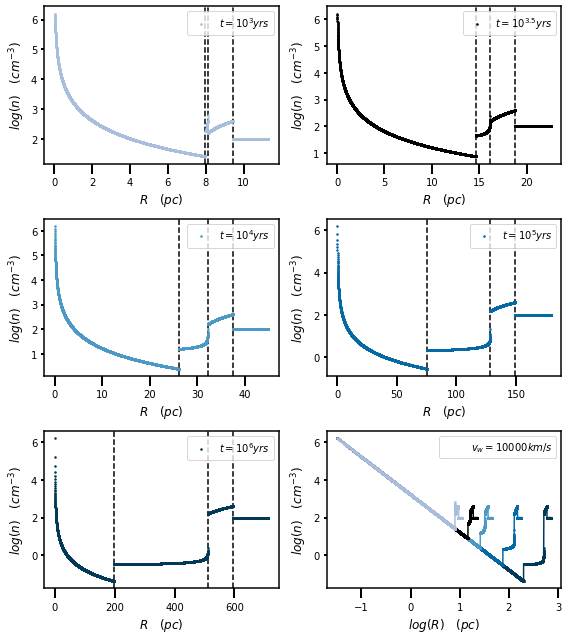

In [45]:
#---Plot log(n) vs R for different timesteps

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 9))
#---t=10^3yr
axes[0,0].axvline(x=R1_t1[0],color='black',linestyle="--")
axes[0,0].axvline(x=Rc_t1[0],color='black',linestyle="--")
axes[0,0].axvline(x=R2_t1[0],color='black',linestyle="--")
axes[0,0].plot((r_t1[1]),np.log10(p_t1[1]),c=cmap.to_rgba(8),linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
#axes[0,0].set_ylim(-2,4)
#axes[0,0].set_xlim(0,15)
axes[0,0].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[0,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,0].legend(loc='upper right')
#---t=10^3.5yr
axes[0,1].axvline(x=R1_t1[4],color='black',linestyle="--")
axes[0,1].axvline(x=Rc_t1[4],color='black',linestyle="--")
axes[0,1].axvline(x=R2_t1[4],color='black',linestyle="--")
axes[0,1].plot((r_t1[5]),np.log10(p_t1[5]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{3.5} yrs$')
#axes[0,1].set_ylim(-2,4)
#axes[0,1].set_xlim(0,30)
axes[0,1].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[0,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,1].legend(loc='upper right')
#---t=10^4yr
axes[1,0].axvline(x=R1_t1[1],color='black',linestyle="--")
axes[1,0].axvline(x=Rc_t1[1],color='black',linestyle="--")
axes[1,0].axvline(x=R2_t1[1],color='black',linestyle="--")
axes[1,0].plot((r_t1[2]),np.log10(p_t1[2]),c=cmap.to_rgba(12),linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
#axes[1,0].set_ylim(-2,4)
#axes[1,0].set_xlim(0,60)
axes[1,0].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[1,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,0].legend(loc='upper right')
#---t=10^5yr
axes[1,1].axvline(x=R1_t1[2],color='black',linestyle="--")
axes[1,1].axvline(x=Rc_t1[2],color='black',linestyle="--")
axes[1,1].axvline(x=R2_t1[2],color='black',linestyle="--")
axes[1,1].plot((r_t1[3]),np.log10(p_t1[3]),c=cmap.to_rgba(16),linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
#axes[1,1].set_ylim(-2,4)
#axes[1,1].set_xlim(0,250)
axes[1,1].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[1,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,1].legend(loc='upper right')
#---t=10^6yr
axes[2,0].axvline(x=R1_t1[3],color='black',linestyle="--")
axes[2,0].axvline(x=Rc_t1[3],color='black',linestyle="--")
axes[2,0].axvline(x=R2_t1[3],color='black',linestyle="--")
axes[2,0].plot((r_t1[4]),np.log10(p_t1[4]),c=cmap.to_rgba(20),linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
#axes[2,0].set_ylim(-2,4)
#axes[2,0].set_xlim(0,1000)
axes[2,0].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[2,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[2,0].legend(loc='upper right')
#---all t
plt.plot([], [], ' ', label=r'$v_w=10000km/s$')
axes[2,1].plot(np.log10(r_t1[4]),np.log10(p_t1[4]),c=cmap.to_rgba(20),linestyle="-",marker='.',markersize=3)#,label=r'$t=10^{6} yrs$')
axes[2,1].plot(np.log10(r_t1[3]),np.log10(p_t1[3]),c=cmap.to_rgba(16),linestyle="-",marker='.',markersize=3)#,label=r'$t=10^{5} yrs$')
axes[2,1].plot(np.log10(r_t1[2]),np.log10(p_t1[2]),c=cmap.to_rgba(12),linestyle="-",marker='.',markersize=3)#,label=r'$t=10^{4} yrs$')
axes[2,1].plot(np.log10(r_t1[5]),np.log10(p_t1[5]),color='black',linestyle="-",marker='.',markersize=3)#,label=r'$t=10^{3.5} yrs$')
axes[2,1].plot(np.log10(r_t1[1]),np.log10(p_t1[1]),c=cmap.to_rgba(8),linestyle="-",marker='.',markersize=3)#,label=r'$t=10^{3} yrs$')
#axes[2,1].set_ylim(-2,4)
#axes[2,1].set_xlim(0,3)
axes[2,1].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[2,1].set_xlabel(r'$log(R) \quad (pc)$', fontsize=12)
axes[2,1].legend(loc='upper right')

plt.tight_layout()
#plt.savefig('vw10000/ShockBubble_lognVSr_all2_vw10000.png',bbox_inches='tight')
plt.show()

## Plot n(v_gas)

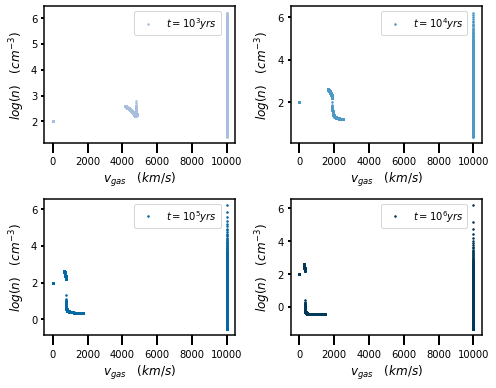

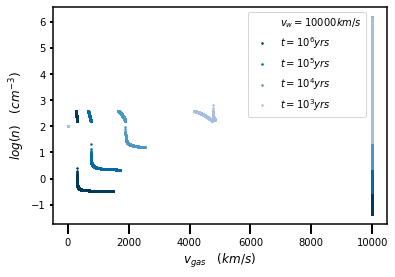

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].plot((vg_t1[1]),np.log10(p_t1[1]),c=cmap.to_rgba(8),linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[0,0].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[0,0].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^4yr
axes[0,1].plot((vg_t1[2]),np.log10(p_t1[2]),c=cmap.to_rgba(12),linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[0,1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[0,1].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^5yr
axes[1,0].plot((vg_t1[3]),np.log10(p_t1[3]),c=cmap.to_rgba(16),linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[1,0].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[1,0].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^6yr
axes[1,1].plot((vg_t1[4]),np.log10(p_t1[4]),c=cmap.to_rgba(20),linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[1,1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[1,1].legend(loc='upper right',bbox_to_anchor =(0.95,1))

plt.tight_layout()
#plt.savefig('vw10000/ShockBubble_lognVSvgas_sublpots_vw10000.png',bbox_inches='tight')
plt.show()


#Plot log(n) vs (vgas) for different t steps
plt.plot([], [], ' ', label=r'$v_w=10000km/s$')
plt.plot((vg_t1[4]),np.log10(p_t1[4]),c=cmap.to_rgba(20),linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot((vg_t1[3]),np.log10(p_t1[3]),c=cmap.to_rgba(16),linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot((vg_t1[2]),np.log10(p_t1[2]),c=cmap.to_rgba(12),linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot((vg_t1[1]),np.log10(p_t1[1]),c=cmap.to_rgba(8),linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='upper right', bbox_to_anchor =(0.95,1))
#plt.xlim(-1000,12000)
#plt.ylim(-2.5,6)
plt.ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
plt.xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
#plt.savefig('vw10000/ShockBubble_lognVSvgas_vw10000.png',bbox_inches='tight')
plt.show()

# Calc Var Plots (dv/dt, N)

## Plot log(dv/dt) vs log(R) 
- (at all t) before and after shock

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero en

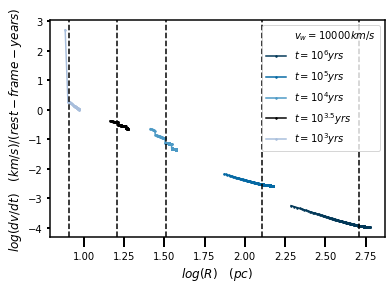

In [47]:
plt.plot([], [], ' ', label=r'$v_w=10000km/s$')
plt.plot(np.log10(r1_dm[4]),np.log10(dv_dt[4]),c=cmap.to_rgba(20),linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.axvline(np.log10(Rc_t1[3]),color='black',linestyle="--")
plt.plot(np.log10(r1_dm[3]),np.log10(dv_dt[3]),c=cmap.to_rgba(16),linestyle="-",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.axvline(np.log10(Rc_t1[2]),color='black',linestyle="--")
plt.plot(np.log10(r1_dm[2]),np.log10(dv_dt[2]),c=cmap.to_rgba(12),linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.axvline(np.log10(Rc_t1[1]),color='black',linestyle="--")
plt.plot(np.log10(r1_dm[5]),np.log10(dv_dt[5]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3.5} yrs$')
plt.axvline(np.log10(Rc_t1[4]),color='black',linestyle="--")
plt.plot(np.log10(r1_dm[1]),np.log10(dv_dt[1]),c=cmap.to_rgba(8),linestyle="-",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.axvline(np.log10(Rc_t1[0]),color='black',linestyle="--")
plt.legend(loc='upper right')
plt.xlabel(r'$log(R) \quad (pc)$', fontsize=12)
plt.ylabel(r'$log(dv/dt) \quad (km/s)/(rest-frame-years)$', fontsize=12)
#plt.savefig('vw10000/ShockBubble_logdvdtVSlogr_vw10000.png',bbox_inches='tight')
plt.show()

## Plot dv/dt vs v_gas 
- (at all t) before and after shock

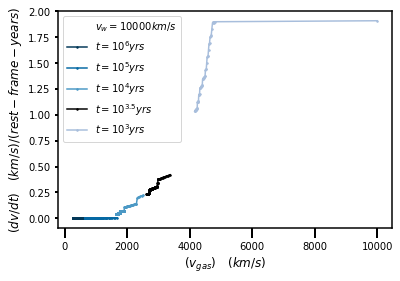

In [48]:
plt.plot([], [], ' ', label=r'$v_w=10000km/s$')
plt.plot((v1_dm_cut[4]),(dv_dt_cut[4]),c=cmap.to_rgba(20),linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot((v1_dm_cut[3]),(dv_dt_cut[3]),c=cmap.to_rgba(16),linestyle="-",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot((v1_dm_cut[2]),(dv_dt_cut[2]),c=cmap.to_rgba(12),linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot((v1_dm_cut[5]),(dv_dt_cut[5]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3.5} yrs$')
plt.plot((v1_dm_cut[1]),(dv_dt_cut[1]),c=cmap.to_rgba(8),linestyle="-",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='upper left')
#plt.xlim(0,7000)
#plt.ylim(-0.1,3.5)
plt.xlabel(r'$(v_{gas}) \quad (km/s)$', fontsize=12)
plt.ylabel(r'$(dv/dt) \quad (km/s)/(rest-frame-years)$', fontsize=12)
#plt.savefig('vw10000/ShockBubble_dvdtVSv_vw10000.png',bbox_inches='tight')
plt.show()

## Plot log(N) vs log(R) 
- (at all t) before and after shock

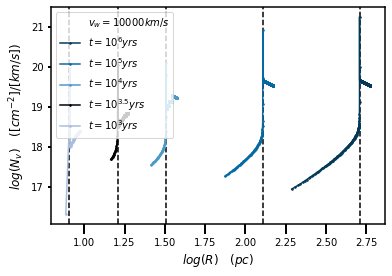

In [49]:
plt.plot([], [], ' ', label=r'$v_w=10000km/s$')
plt.axvline(np.log10(Rc_t1[3]),color='black',linestyle="--")
plt.plot(np.log10(r1_dm_cut[4]),np.log10(N1_dm[4]),c=cmap.to_rgba(20),linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.axvline(np.log10(Rc_t1[2]),color='black',linestyle="--")
plt.plot(np.log10(r1_dm_cut[3]),np.log10(N1_dm[3]),c=cmap.to_rgba(16),linestyle="-",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.axvline(np.log10(Rc_t1[1]),color='black',linestyle="--")
plt.plot(np.log10(r1_dm_cut[2]),np.log10(N1_dm[2]),c=cmap.to_rgba(12),linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.axvline(np.log10(Rc_t1[4]),color='black',linestyle="--")
plt.plot(np.log10(r1_dm_cut[5]),np.log10(N1_dm[5]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3.5} yrs$')
plt.axvline(np.log10(Rc_t1[0]),color='black',linestyle="--")
plt.plot(np.log10(r1_dm_cut[1]),np.log10(N1_dm[1]),c=cmap.to_rgba(8),linestyle="-",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='upper left')
#plt.ylim(16,27)
plt.xlabel(r'$log(R) \quad (pc)$', fontsize=12)
plt.ylabel(r'$log(N_v) \quad ([cm^{-2}]/[km/s])$', fontsize=12)
#plt.savefig('vw10000/ShockBubble_logNVSlogr_vw10000.png',bbox_inches='tight')
plt.show()

## Plot log(N) vs R (t=10^3.5)
- before and after shock

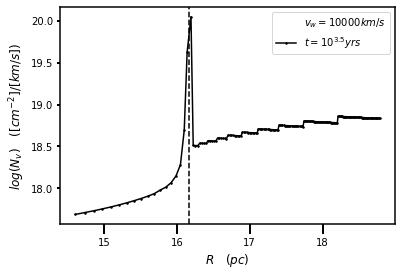

In [50]:
plt.plot([], [], ' ', label=r'$v_w=10000km/s$')
plt.plot((r1_dm_cut[5]),np.log10(N1_dm[5]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3.5} yrs$')
plt.axvline((Rc_t1[4]),color='black',linestyle="--")
plt.legend(loc='upper right')
#plt.ylim(16,26)
plt.xlabel(r'$R \quad (pc)$', fontsize=12)
plt.ylabel(r'$log(N_v) \quad ([cm^{-2}]/[km/s])$', fontsize=12)
#plt.savefig('vw10000/ShockBubble_logNVSr_t10^3.5_vw10000.png',bbox_inches='tight')
plt.show()

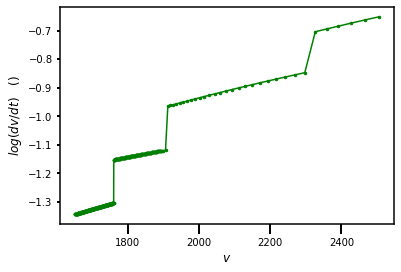

In [51]:
#Plot N vs R (at all t) before and after shock

#plt.plot((r1_dm_cut[2]),(v1_dm_cut[2]),color='green',linestyle="",marker='.',markersize=1,label=r'$t=10^{4} yrs$')
#plt.ylim(2000,2600); plt.xlim(40,48)

#plt.plot((r1_dm_cut[2]),(N1_dm[2]),color='green',linestyle="",marker='.',markersize=5,label=r'$t=10^{4} yrs$')
#plt.ylim(0.0,1.0*(10**20)); plt.xlim(40,48)

#plt.plot((r1_dm_cut[2]),(dv_dt_cut[2]),color='green',linestyle="",marker='.',markersize=5,label=r'$t=10^{4} yrs$')
#plt.ylim(0.08,0.1); plt.xlim(40,48)

#plt.plot((r1_dm_cut[2]),np.log10(dv_dt_cut[2]),color='green',linestyle="",marker='.',markersize=5,label=r'$t=10^{4} yrs$')
#plt.ylim(-1.1,-0.8); plt.xlim(40,48)

#plt.plot((v1_dm_cut[2]),(dv_dt_cut[2]),color='green',linestyle="",marker='.',markersize=5,label=r'$t=10^{4} yrs$')
#plt.ylim(0.08,0.1); plt.xlim(2000,2400)

plt.plot((v1_dm_cut[2]),np.log10(dv_dt_cut[2]),color='green',linestyle="-",marker='.',markersize=5,label=r'$t=10^{4} yrs$')
#plt.ylim(0.08,0.1); plt.xlim(2000,2400)

plt.xlabel(r'$v$', fontsize=12)
plt.ylabel(r'$log(dv/dt) \quad ()$', fontsize=12)
#plt.savefig('Weaver&FGShockBubble_logNVSlogr_constdM_t=10^3-10^6_cut.png',bbox_inches='tight')
plt.show()

## Plot log(N) vs vgas 
-(at all t) before and after shock

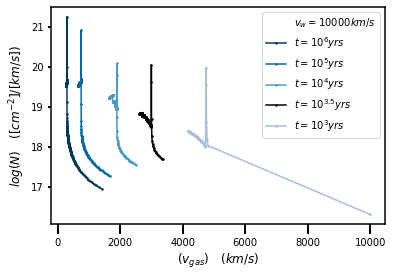

In [52]:
plt.plot([], [], ' ', label=r'$v_w=10000km/s$')
plt.plot((v1_dm_cut[4]),np.log10(N1_dm[4]),c=cmap.to_rgba(20),linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot((v1_dm_cut[3]),np.log10(N1_dm[3]),c=cmap.to_rgba(16),linestyle="-",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot((v1_dm_cut[2]),np.log10(N1_dm[2]),c=cmap.to_rgba(12),linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot((v1_dm_cut[5]),np.log10(N1_dm[5]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3.5} yrs$')
plt.plot((v1_dm_cut[1]),np.log10(N1_dm[1]),c=cmap.to_rgba(8),linestyle="-",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='upper right')
#plt.ylim(16,26)
plt.xlabel(r'$(v_{gas}) \quad (km/s)$', fontsize=12)
plt.ylabel(r'$log(N) \quad ([cm^{-2}]/[km/s])$', fontsize=12)
#plt.savefig('vw10000/ShockBubble_logNVSv_vw10000.png',bbox_inches='tight')
plt.show()

## Plot log(dv/dt) VS log(N)

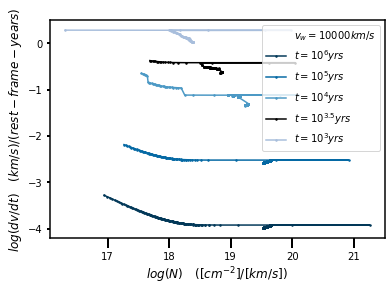

In [53]:
plt.plot([], [], ' ', label=r'$v_w=10000km/s$')
plt.plot(np.log10(N1_dm[4]),np.log10(dv_dt_cut[4]),c=cmap.to_rgba(20),linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot(np.log10(N1_dm[3]),np.log10(dv_dt_cut[3]),c=cmap.to_rgba(16),linestyle="-",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot(np.log10(N1_dm[2]),np.log10(dv_dt_cut[2]),c=cmap.to_rgba(12),linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot(np.log10(N1_dm[5]),np.log10(dv_dt_cut[5]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3.5} yrs$')
plt.plot(np.log10(N1_dm[1]),np.log10(dv_dt_cut[1]),c=cmap.to_rgba(8),linestyle="-",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='upper right')
#plt.xlim(16,24)
plt.ylabel(r'$log(dv/dt) \quad (km/s)/(rest-frame-years)$', fontsize=12)
plt.xlabel(r'$log(N) \quad ([cm^{-2}]/[km/s])$', fontsize=12)
#plt.savefig('vw10000/ShockBubble_logdvdtVSlogN_vw10000.png',bbox_inches='tight')
plt.show()